**Trajectory analysis from seurat object using monocle3

Dataset:GSE164772

Author: Kei Onn, Lai**




Here i read in the seurat object (mgclusters_only_seuratint.rds) 
from the previous analysis(1. Seurat_scrnaseq_GSE164772.Rmd) as "seurat.rds" 
seurat.rds thus contains only microglia population from GSE164772. 
Previously, using seurat,i identified 7 microglia populations. 
In this pipeline, we will use monocle3 for a trajectory anlaysis for these 7 microglia population in zebrafish.



In [1]:

.libPaths("C:/Program Files/R/R-4.2.1/library")

.libPaths()

setwd("C:/Users/Kei Onn/Downloads")
suppressPackageStartupMessages(library(SeuratWrappers))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(monocle3))
suppressPackageStartupMessages(library(SingleCellExperiment))
suppressPackageStartupMessages(library(SummarizedExperiment)) 
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))

[1] "C:/Program Files/R/R-4.2.1/library"

Warning message:
"package 'Seurat' was built under R version 4.2.2"
Warning message:
"package 'matrixStats' was built under R version 4.2.2"
Warning message:
"package 'ggplot2' was built under R version 4.2.2"
Warning message:
"package 'dplyr' was built under R version 4.2.2"


In [2]:
getwd()

[1] "C:/Users/Kei Onn/Downloads"

creating cell dataset object from seurat object using SeuratWrapper

In [3]:
seurat<-readRDS("mgclusters_only_seuratint.RDS")
cds<-as.cell_data_set(seurat)
#meta data
colData(cds)

DataFrame with 5833 rows and 26 columns
                             orig.ident nCount_RNA nFeature_RNA  seq_folder
                            <character>  <numeric>    <integer> <character>
Juvenile_AAACGAAAGGTGCCAA_1    Juvenile       4329         1383    Juvenile
Juvenile_AAACGCTAGATGACCG_1    Juvenile       5795         2099    Juvenile
Juvenile_AAAGAACCAGATTCGT_1    Juvenile       5195         1766    Juvenile
Juvenile_AAAGGGCAGAATACAC_1    Juvenile       8578         1983    Juvenile
Juvenile_AAAGGTATCTCCTGCA_1    Juvenile       3139         1203    Juvenile
...                                 ...        ...          ...         ...
Adult_TTTGGAGGTTAAGGAT_3          Adult       3608         1052       Adult
Adult_TTTGGTTTCGTAACTG_3          Adult       1876          859       Adult
Adult_TTTGGTTTCTTCGGAA_3          Adult       3333         1090       Adult
Adult_TTTGTTGGTCCGGCAT_3          Adult       1252          654       Adult
Adult_TTTGTTGTCCCTTGGT_3          Adult       14

getting feature data aka the data of genes

In [4]:
fData(cds)
fData(cds)$gene_short_name<-rownames(fData(cds))
fData(cds)
# we added extra col of gene_short_name

#checking how cds counts look like
counts(cds)[1:6,1:6]

DataFrame with 16818 rows and 0 columns

DataFrame with 16818 rows and 1 column
               gene_short_name
                   <character>
ptpn12                  ptpn12
phtf2.1                phtf2.1
CU856344.1          CU856344.1
lrp6                      lrp6
dusp16                  dusp16
...                        ...
CABZ01078055.1  CABZ01078055.1
CABZ01069162.1  CABZ01069162.1
CABZ01090361.1  CABZ01090361.1
CABZ01118270.1  CABZ01118270.1
CABZ01109604.1  CABZ01109604.1

6 x 6 sparse Matrix of class "dgCMatrix"
           Juvenile_AAACGAAAGGTGCCAA_1 Juvenile_AAACGCTAGATGACCG_1
ptpn12                               .                           .
phtf2.1                              .                           .
CU856344.1                           .                           .
lrp6                                 .                           .
dusp16                               .                           .
crebl2                               .                           .
           Juvenile_AAAGAACCAGATTCGT_1 Juvenile_AAAGGGCAGAATACAC_1
ptpn12                               .                           .
phtf2.1                              .                           .
CU856344.1                           .                           .
lrp6                                 .                           .
dusp16                               .                           .
crebl2                               .                           .
           Juvenile_A

For trajectory analysis, monocle3 needs cell embeddings of UMAP, partitions and the clusters. so, i used cluster_cells() from monocle3 to these information rather than using just seurat object.

In [5]:
cds <- cluster_cells(cds, resolution=1e-3)

p1 <- plot_cells(cds, color_cells_by = "cluster", show_trajectory_graph = FALSE)
p2 <- plot_cells(cds, color_cells_by = "partition", show_trajectory_graph = FALSE)

Warning message:
"package 'patchwork' was built under R version 4.2.2"


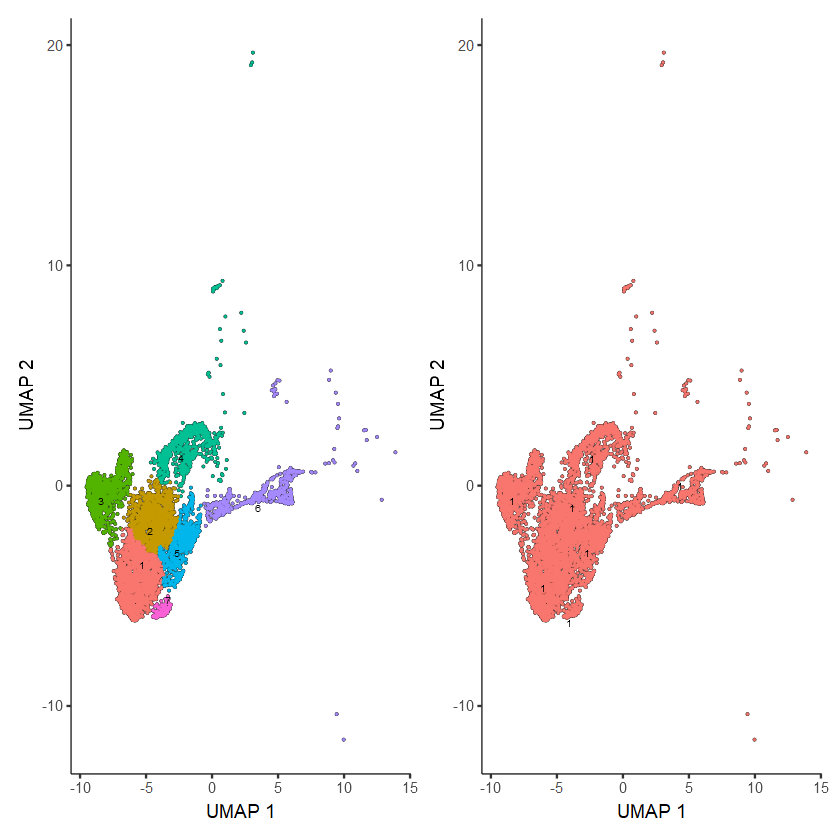

In [6]:
suppressPackageStartupMessages(library(patchwork))
wrap_plots(p1, p2)

In [7]:
integrated.sub <- subset(as.Seurat(cds, assay = NULL), monocle3_partitions == 1) 
# only consider 1 partition here, I do not wish to consider larger clusters than my already found clusters
cds <- as.cell_data_set(integrated.sub)
cds <- learn_graph(cds, use_partition = TRUE, verbose = FALSE) #this finds how the cell clusters change acc to pseudotime

Using existing Monocle 3 cluster membership and partitions



  |======================================================================| 100%


In [8]:
trajplot<-plot_cells(cds,
           color_cells_by = "cluster",
           label_groups_by_cluster=FALSE,
           label_leaves=FALSE,
           label_branch_points=FALSE)+theme(legend.position = "right")

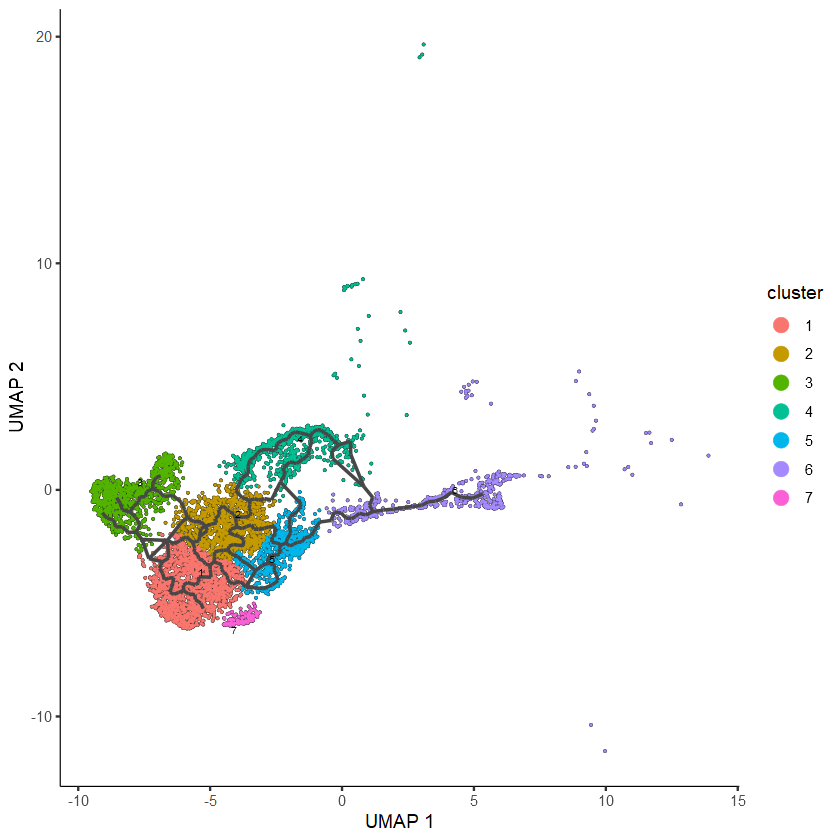

In [9]:


trajplot

we know that microglia population 6 is proliferative microglia since Ki67 is a cluster specific marker of microglia6,
and therefore, it's likely to be the
root of the pseudotime plot 

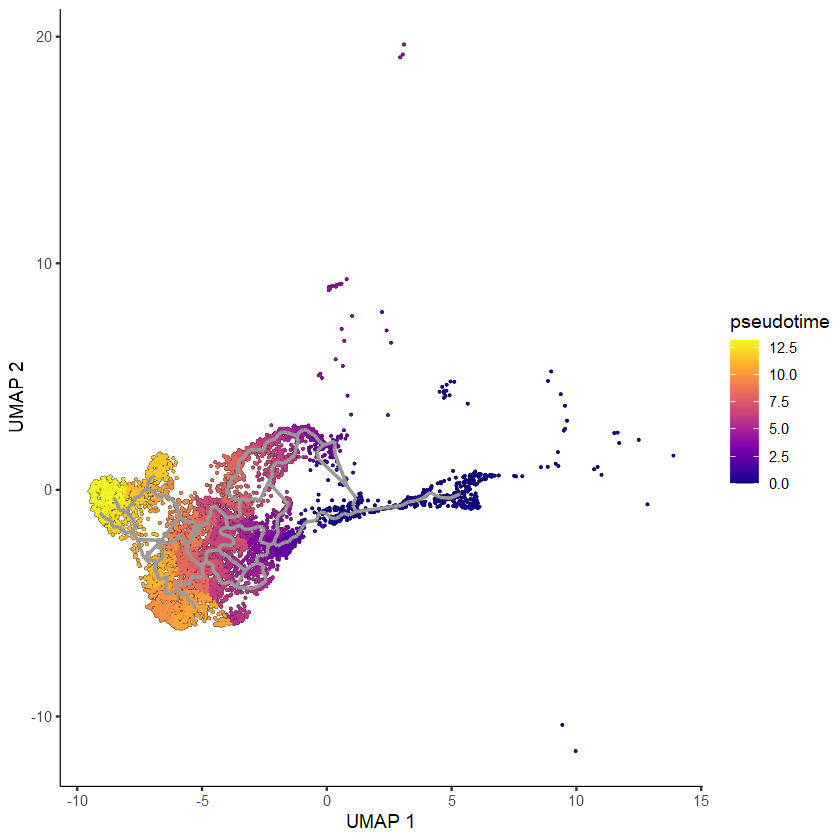

In [10]:
cds <- order_cells(cds, root_cells = colnames(cds[,clusters(cds) == 6])) #setting root of pseudotime
pseudot<-plot_cells(cds,
           color_cells_by = "pseudotime",
           group_cells_by = "cluster",
           label_cell_groups = FALSE,
           label_groups_by_cluster=FALSE,
           label_leaves=FALSE,
           label_branch_points=FALSE,
           label_roots = FALSE,
           trajectory_graph_color = "grey60")
pseudot

Since cluster 3 is furthest from cluster 6,
we do pairwise comparison

In [11]:
cluster3vs6<-FindMarkers(seurat, ident.1 = "Microglia3", ident.2 = "Microglia6")
head(cluster3vs6)


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
tubb2b,4.360532e-171,-3.180746,0.468,0.987,7.333543e-167
si:ch211-288g17.3,1.142157e-159,-2.434311,0.288,0.958,1.920880e-155
hmgb2b,1.642520e-157,-2.542477,0.518,0.983,2.762389e-153
tuba8l4,1.061762e-156,-1.867765,0.933,1.000,1.785671e-152
hmgb2a,3.866046e-147,-2.706830,0.780,0.987,6.501916e-143
mki67,1.095526e-146,-3.142942,0.035,0.743,1.842456e-142


extracting genes that vary across the pseudotime

#the following command takes really long,i will not run it as my local machine does not have enough memory
cds_graph_test_results <- graph_test(cds,
                                     neighbor_graph = "principal_graph",
                                     cores = 8)
#write.csv(cds_graph_test_results,"genes_vary_pseudotime.csv")

#write as RDS object saveRDS(cds_graph_test_results,file="cds_graph_test_results.RDS")

In [12]:

cds_graph_test_results<-readRDS(file="cds_graph_test_results.RDS") #previously ran and saved object

In [13]:
head(cds_graph_test_results)

,genename,status,p_value,morans_test_statistic,morans_I,q_value,entrez
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ptpn12,OK,0.5888466,-0.2245790,-0.0009709577,0.7554940,393642
2,phtf2.1,OK,0.1687789,0.9590020,0.0034038378,0.3423483,NA
3,CU856344.1,OK,0.6898364,-0.4953868,-0.0019465047,0.7816578,NA
4,lrp6,OK,0.6518412,-0.3902962,-0.0014895879,0.7656944,100003877
5,dusp16,OK,0.7109810,-0.5562528,-0.0023456317,0.7935380,406523
6,crebl2,OK,0.1507832,1.0330801,0.0038797757,0.3131117,436975


In [14]:
rownames(cds_graph_test_results)<-cds_graph_test_results$genename
head(cds_graph_test_results)

,genename,status,p_value,morans_test_statistic,morans_I,q_value,entrez
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ptpn12,ptpn12,OK,0.5888466,-0.2245790,-0.0009709577,0.7554940,393642
phtf2.1,phtf2.1,OK,0.1687789,0.9590020,0.0034038378,0.3423483,NA
CU856344.1,CU856344.1,OK,0.6898364,-0.4953868,-0.0019465047,0.7816578,NA
lrp6,lrp6,OK,0.6518412,-0.3902962,-0.0014895879,0.7656944,100003877
dusp16,dusp16,OK,0.7109810,-0.5562528,-0.0023456317,0.7935380,406523
crebl2,crebl2,OK,0.1507832,1.0330801,0.0038797757,0.3131117,436975


In [15]:
rowData(cds)$gene_short_name <- row.names(rowData(cds))
head(cds_graph_test_results, error=FALSE, message=FALSE, warning=FALSE)

,genename,status,p_value,morans_test_statistic,morans_I,q_value,entrez
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ptpn12,ptpn12,OK,0.5888466,-0.2245790,-0.0009709577,0.7554940,393642
phtf2.1,phtf2.1,OK,0.1687789,0.9590020,0.0034038378,0.3423483,NA
CU856344.1,CU856344.1,OK,0.6898364,-0.4953868,-0.0019465047,0.7816578,NA
lrp6,lrp6,OK,0.6518412,-0.3902962,-0.0014895879,0.7656944,100003877
dusp16,dusp16,OK,0.7109810,-0.5562528,-0.0023456317,0.7935380,406523
crebl2,crebl2,OK,0.1507832,1.0330801,0.0038797757,0.3131117,436975


In [16]:
cds_graph_test_results_sig<-subset(cds_graph_test_results, q_value < 0.05) %>% arrange(desc(morans_I))
head(cds_graph_test_results_sig)

str(cds_graph_test_results_sig)



,genename,status,p_value,morans_test_statistic,morans_I,q_value,entrez
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
hmgb2a,hmgb2a,OK,0,197.0853,0.7776487,0,641484
hmgn2,hmgn2,OK,0,192.2318,0.7584317,0,569904
mki67,mki67,OK,0,192.2745,0.7567913,0,564521
stmn1a,stmn1a,OK,0,183.2332,0.7208930,0,678630
zgc:165555.12,zgc:165555.12,OK,0,176.5806,0.6962456,0,NA
tubb2b,tubb2b,OK,0,175.6265,0.6932457,0,641421


'data.frame':	5790 obs. of  7 variables:
 $ genename             : chr  "hmgb2a" "hmgn2" "mki67" "stmn1a" ...
 $ status               : chr  "OK" "OK" "OK" "OK" ...
 $ p_value              : num  0 0 0 0 0 0 0 0 0 0 ...
 $ morans_test_statistic: num  197 192 192 183 177 ...
 $ morans_I             : num  0.778 0.758 0.757 0.721 0.696 ...
 $ q_value              : num  0 0 0 0 0 0 0 0 0 0 ...
 $ entrez               : chr  "641484" "569904" "564521" "678630" ...


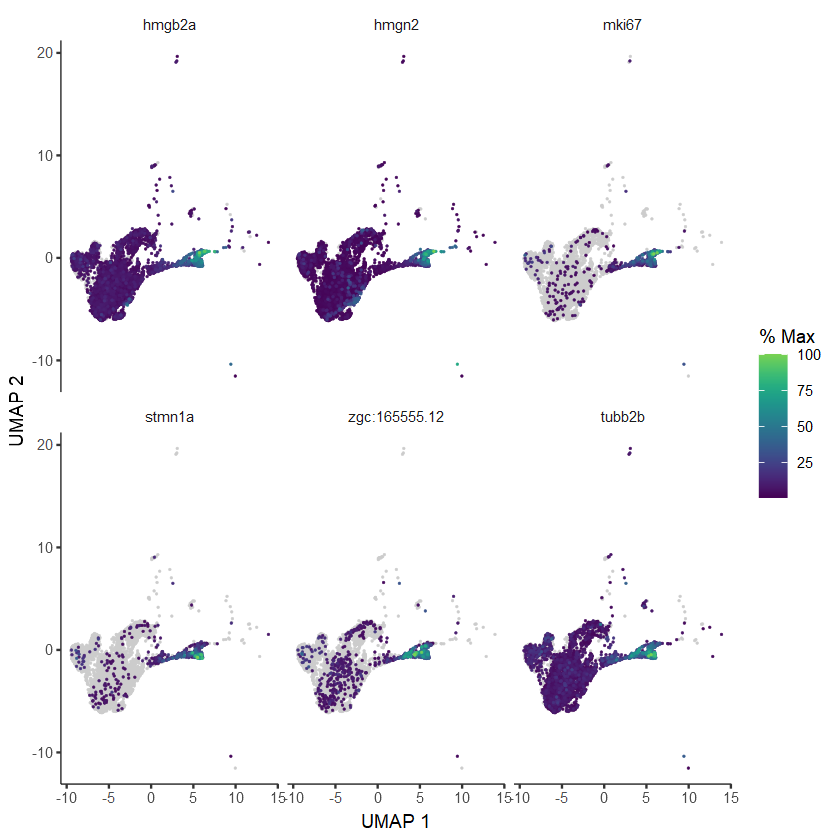

In [17]:
deg_ids <- rownames(subset(cds_graph_test_results[order(cds_graph_test_results$morans_I, decreasing = TRUE),], q_value < 0.05))

plot_cells(cds,
           genes=head(deg_ids),
           show_trajectory_graph = FALSE,
           label_cell_groups = FALSE,
           label_leaves = FALSE)

plotting as a function of time,
in this case, we are interested in the top few genes of deg_ids ranked prev by moran's I


In [18]:
topgenes_cds <- cds[rowData(cds)$gene_short_name %in% head(deg_ids),]

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"


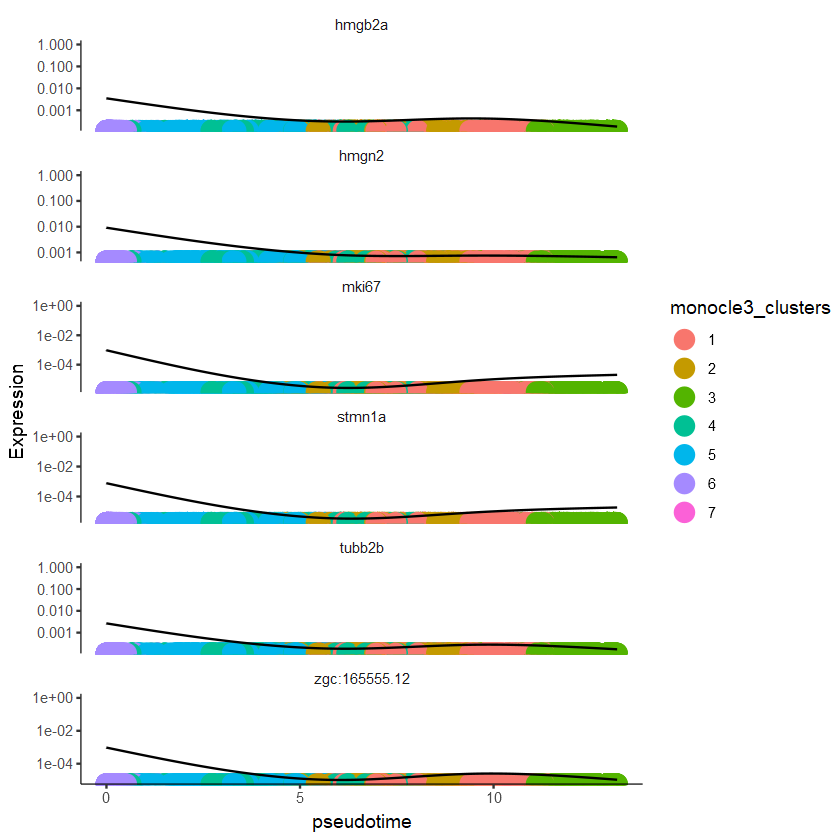

In [19]:
plot_pseudot<-plot_genes_in_pseudotime(topgenes_cds,color_cells_by = "monocle3_clusters"
                                   ,cell_size = 5) #plot indiv top genes as function of pseudotime
plot_pseudot